# Aicraft recognition system

This is a model to recognize aircraft models based on pictures.

Necessary imports

Ref: 
https://towardsdatascience.com/deep-cars-transfer-learning-with-pytorch-3e7541212e85


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

/home/santiago/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


Function to annotation files on pandas dataframes

In [2]:
def load_annotation(filename, labelname):
    file_list = []

    with open(filename) as file:
        for line in file:
            line = line.split()
            imagefilename = line[0] + ".jpg"
            label = " ".join(line[1:])
            file_list.append([imagefilename, label])

    dataframe = pd.DataFrame(file_list)
    dataframe.columns = ["File", labelname]
    return dataframe

Now I load the annotation files

In [3]:
annotations_path = "../fgvc-aircraft-2013b/data"

manufacturers_train_file = os.path.join(annotations_path, "images_manufacturer_trainval.txt")
manufacturers_test_file = os.path.join(annotations_path, "images_manufacturer_test.txt")
family_train_file = os.path.join(annotations_path, "images_family_trainval.txt")
family_test_file = os.path.join(annotations_path, "images_family_test.txt")
variant_train_file = os.path.join(annotations_path, "images_variant_trainval.txt")
variant_test_file = os.path.join(annotations_path, "images_variant_test.txt")

manufacturers_train = load_annotation(manufacturers_train_file, "Manufacturer")
manufacturers_test = load_annotation(manufacturers_test_file, "Manufacturer")
family_train = load_annotation(family_train_file, "Family")
family_test = load_annotation(family_test_file, "Family")
variant_train = load_annotation(variant_train_file, "Variant")
variant_test = load_annotation(variant_test_file, "Variant")

### Create a dictionary of classes

In [4]:
manufacturers_names = list(set(manufacturers_train.iloc[:,1]))
manufacturer_name_id = {name: id for name, id in zip(manufacturers_names, range(len(manufacturers_names)))}
manufacturer_id_name = {id: name for name, id in manufacturer_name_id.items()}

family_names = list(set(family_train.iloc[:,1]))
family_name_id = {name: id for name, id in zip(family_names, range(len(family_names)))}
family_id_name = {id: name for name, id in family_name_id.items()}

variant_names = list(set(variant_train.iloc[:,1]))
variant_name_id = {name: id for name, id in zip(variant_names, range(len(variant_names)))}
variant_id_name = {id: name for name, id in variant_name_id.items()}

num_manufacturers = len(manufacturers_names)
num_family = len(family_names)
num_variant = len(variant_names)

print(f"Total Manufacturers: {num_manufacturers}")
print(f"Total Families: {num_family}")
print(f"Total Variant: {num_variant}")

Total Manufacturers: 30
Total Families: 70
Total Variant: 100


Simple function to show images

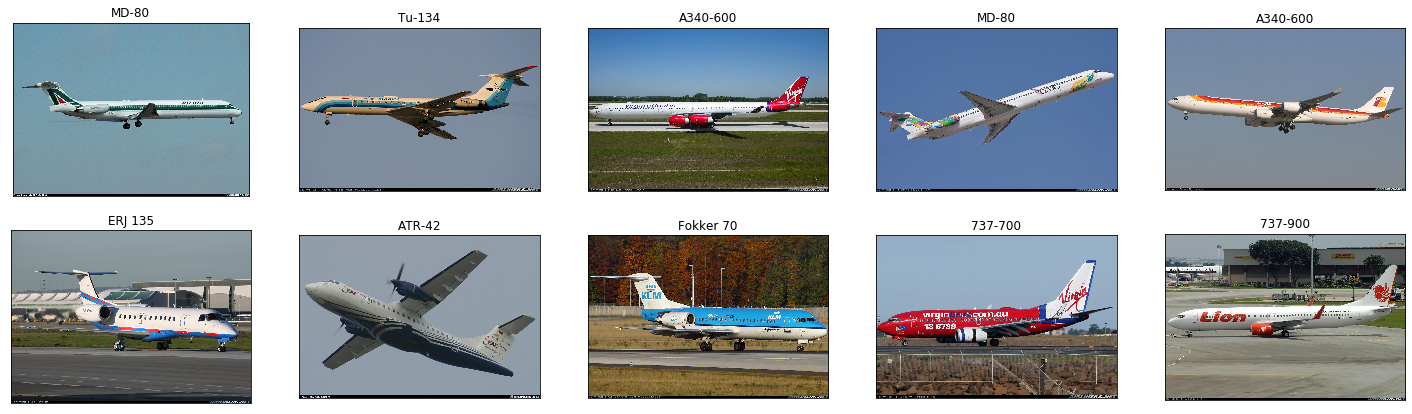

In [5]:
images_path = "../fgvc-aircraft-2013b/data/images"
samples_num = 10
sample = variant_train.sample(samples_num)

fig = plt.figure(figsize=(25,7))

for (_, image), idx in zip(sample.iterrows(), range(samples_num)):
    axes = fig.add_subplot(2, samples_num/2, idx+1, xticks=[], yticks=[])
    plt.imshow(io.imread(os.path.join(images_path, image["File"])))
    axes.set_title(image["Variant"])

## Defining the dataset class

Now we are going to write a custom dataset, since our data is not organized by folder/class as usual.

For this, I used the custom dataset tutorial available at:
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

But first we will define a function to cut out the bottom banner that is present in each picture

In [6]:
def cut_bottom_banner(image, banner_height=20):
    x,_,_ = image.shape
    return image[0:x-banner_height,:,:]

In [7]:
class AircraftDataset(Dataset):
    
    def __init__(self, dataframe, images_dir, name_id_dict, transform=None):
        """ 
            Args:
            pd.DataFrame dataframe: A dataframe with the name of the image files and the label of the image
            str images_dir: The directory where the images a stored
            callable, optional transform: The transformations to be applied to the images
        """
        self.aircraft_dataframe = dataframe
        self.images_dir = images_dir
        self.transform = transform
        self.name_id_dict = name_id_dict
        
    def __len__(self):
        return len(self.aircraft_dataframe)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        image = io.imread(os.path.join(self.images_dir, self.aircraft_dataframe.iloc[idx, 0]))
        class_name = self.aircraft_dataframe.iloc[idx, 1]
        label = self.name_id_dict[class_name]
        
        image = cut_bottom_banner(image)
        
        if self.transform:
            image = self.transform(image)
        
        sample = (image, label)
            
        return sample

Now we will set the transformations for data augmentation and for compatibility with the pre-trained models

In [8]:
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])

transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])

### Create the datasets and dataloaders

In [9]:
manufacturers_train_dataset = AircraftDataset(manufacturers_train, images_path, manufacturer_name_id, transform_train)
manufacturers_test_dataset = AircraftDataset(manufacturers_test, images_path, manufacturer_name_id, transform_test)
family_train_dataset = AircraftDataset(family_train, images_path, family_name_id, transform_train)
family_test_dataset = AircraftDataset(family_test, images_path, family_name_id, transform_test)
variant_dataset = AircraftDataset(variant_train, images_path, variant_name_id, transform_train)
variant_test_dataset = AircraftDataset(variant_test, images_path, variant_name_id, transform_test)

In [11]:
val_size = int(0.1 * len(variant_dataset))
train_size = len(variant_dataset) - val_size
variant_train_dataset, variant_val_dataset = torch.utils.data.random_split(variant_dataset, [train_size, val_size])

batch_size = 20
variant_dataloader = {'train': DataLoader(variant_train_dataset, batch_size=batch_size, 
                                            shuffle=True, num_workers=0),
                      'val': DataLoader(variant_val_dataset, batch_size=batch_size, 
                                            shuffle=False, num_workers=0)}
variant_test_dataloader = DataLoader(variant_test_dataset, batch_size=batch_size, 
                                            shuffle=False, num_workers=0)

In [ ]:
batch_size = 20

manufacturers_train_dataloader = DataLoader(manufacturers_train_dataset, batch_size=batch_size, 
                                            shuffle=True, num_workers=0)
manufacturers_test_dataloader = DataLoader(manufacturers_test_dataset, batch_size=batch_size, 
                                            shuffle=True, num_workers=0)
family_train_dataloader = DataLoader(family_train_dataset, batch_size=batch_size, 
                                            shuffle=True, num_workers=0)
family_test_dataloader = DataLoader(family_test_dataset, batch_size=batch_size, 
                                            shuffle=True, num_workers=0)
variant_train_dataloader = DataLoader(variant_train_dataset, batch_size=batch_size, 
                                            shuffle=True, num_workers=0)
variant_test_dataloader = DataLoader(variant_test_dataset, batch_size=batch_size, 
                                            shuffle=True, num_workers=0)

### Function to show a batch of images

In [12]:
def show_images_batch(sample_batch, id_name_dict):
    """Show images of a batch of images"""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    images_batch, labels_batch = sample_batch
    batch_size = len(images_batch)
    
    fig = plt.figure(figsize=(25,7))

    for image, label, idx in zip(images_batch, labels_batch, range(batch_size)):
        axes = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
        np_image = image.detach().cpu().numpy().transpose((1, 2, 0))
        np_image = std * np_image + mean
        np_image = np.clip(np_image, 0, 1)
        plt.imshow(np_image)
        axes.set_title(id_name_dict[label.item()])

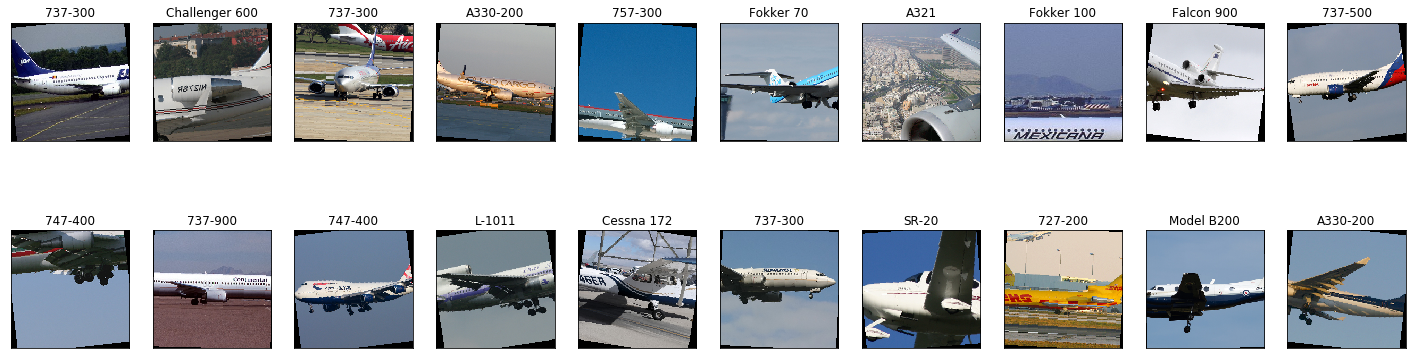

In [13]:
show_images_batch(next(iter(variant_dataloader['train'])), variant_id_name)

### Now it is time to train the model

In [14]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [15]:
def train_model(model, criterion, optimizer, scheduler, dataloader, num_epochs=2):
    
    print_every = 100
    
    validation_loss_min = np.Inf
    
    for epoch in range(1, num_epochs+1):
        
        training_loss = 0.0
        validation_loss = 0.0
        #batch_num = 1
        
        model.train()
        for images, labels in dataloader['train']:
            if train_on_gpu:
                images = images.cuda()
                labels = labels.cuda()
            
            with torch.set_grad_enabled(True):
                optimizer.zero_grad()
            
                outputs = model(images)
                #_, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
            
                loss.backward()
                optimizer.step()
            
            training_loss += loss.item() * images.size(0)
            scheduler.step()
            
            #if batch_num % print_every == 0:
            #    training_loss = training_loss / (print_every * batch_size)
            #    print(f"Epoch {epoch}/{num_epochs}, Batch {batch_num} - training loss: {training_loss}")
            #    training_loss = 0.0

            #batch_num += 1
            
        model.eval()
        for images, labels in dataloader['val']:
            if train_on_gpu:
                images = images.cuda()
                labels = labels.cuda()
            
            with torch.set_grad_enabled(False):
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            validation_loss += loss.item() * images.size(0)
            
        training_loss = training_loss/train_size
        validation_loss = validation_loss/val_size
        
        print(f"Epoch: {epoch}\tTraining loss: {training_loss:.6f}\tValidation loss: {validation_loss:.6f}")
            
        if (validation_loss < validation_loss_min):
            print("Validation loss decreased ({validation_loss_min:.6f} --> {validation_loss:.6f}). Saving model!")
            torch.save(model.state_dict(), "model_aircraft.pt")
            validation_loss_min = validation_loss
            
    print("Training complete")
    model.load_state_dict(torch.load('model_aircraft.pt'))
    
    return model

### Training a model to predict aricraft variant (feature extractor)

In [ ]:
resnet101_variant = models.resnet101(pretrained=True)

In [ ]:
for param in resnet101_variant.parameters():
    param.requires_grad = False
    
num_ftrs = resnet101_variant.fc.in_features
resnet101_variant.fc = nn.Linear(num_ftrs, num_variant)

if train_on_gpu:
    resnet101_variant = resnet101_variant.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet101_variant.fc.parameters(), lr=0.01)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=10, 
                                                 threshold=0.001, threshold_mode='rel', cooldown=0, 
                                                 min_lr=0, eps=1e-08, verbose=True)

In [ ]:
resnet101_variant = train_model(resnet101_variant, criterion, optimizer, scheduler, 
                               variant_dataloader, num_epochs=100)
torch.save(model.state_dict(), "model_variant.pt")
resnet101_variant.cpu()

### Training a model to predict aricraft variant (Fine Tuning)

In [ ]:
resnet101_variant_ft = models.resnet101(pretrained=True)

In [ ]:
num_ftrs = resnet101_variant_ft.fc.in_features
resnet101_variant_ft.fc = nn.Linear(num_ftrs, num_variant)

if train_on_gpu:
    resnet101_variant_ft = resnet101_variant_ft.cuda()

criterion_ft = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(resnet101_variant_ft.fc.parameters(), lr=0.01)

scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', factor=0.3, patience=10, 
                                                 threshold=0.001, threshold_mode='rel', cooldown=0, 
                                                 min_lr=0, eps=1e-08, verbose=True)

In [ ]:
resnet101_variant_ft = train_model(resnet101_variant_ft, criterion, optimizer, scheduler, 
                               variant_dataloader, num_epochs=100)
torch.save(model.state_dict(), "model_variant_ft.pt")
resnet101_variant_ft.cpu()

In [ ]:
resnet18_manufacturers = models.resnet18(pretrained=True)
print(resnet18_manufacturers)

In [ ]:
for param in resnet18_manufacturers.parameters():
    param.requires_grad = False
    
num_ftrs = resnet18_manufacturers.fc.in_features
resnet18_manufacturers.fc = nn.Linear(num_ftrs, num_manufacturers)

if train_on_gpu:
    resnet18_manufacturers = resnet18_manufacturers.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet18_manufacturers.fc.parameters(), lr=0.001)

In [ ]:
resnet18_manufacturers = train_model(resnet18_manufacturers, criterion, optimizer, manufacturers_train_dataloader)

### Testing the accuracy

In [ ]:
def test_model(model, criterion, dataloader, num_classes, classes_names):
    test_loss = 0.0
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))

    model.eval()
    
    for images, labels in dataloader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
            
        output = model(images)
        
        loss = criterion(output, labels)
        test_loss += loss.item() * images.size(0)
        _, pred = torch.max(output, 1)
        
        correct_tensor = pred.eq(labels.data.view_as(pred))
        correct = np.squeeze(np.squeeze(correct_tensor.cpu().numpy()))

        for i in range(len(labels)):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        
    test_loss = test_loss/num_classes
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(num_manufacturers):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes_names[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes_names[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))
        


In [ ]:
test_model(resnet18_manufacturers, criterion, manufacturers_test_dataloader, num_manufacturers, manufacturers_names)

In [ ]:
resnet50_family = models.resnet50(pretrained=True)
print(resnet50_family)

for param in resnet50_family.parameters():
    param.requires_grad = False
    
num_ftrs = resnet50_family.fc.in_features
resnet50_family.fc = nn.Linear(num_ftrs, num_family)

if train_on_gpu:
    resnet50_family = resnet50_family.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet50_family.fc.parameters(), lr=0.001)

resnet50_family = train_model(resnet50_family, criterion, optimizer, family_train_dataloader)

test_model(resnet50_family, criterion, family_test_dataloader, num_family, family_names)

In [ ]:
print(family_names)